# Kernel Recursive Least Squares (KRLS) & Kernel Least Mean Squares

Example: Time series prediction

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from knlms import *
from krls import *

In [2]:
num_data = 3000

def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(0,1,num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])
    d_true = d_true[2::]
    d = d[2::]
    return np.array(d),np.array(d_true)

In [4]:
# Kernel from Richard Paper
gauss_kernel = lambda u_i,u_j: np.exp(-3.73 * (np.linalg.norm(u_i - u_j,ord=2)**2))
nmse = lambda D_n, Phi_n: np.sum((D_n - Phi_n)**2)

kernel = gauss_kernel
step_size = 0.09
reg_coeff = 0.03
threshold = 0.6
d,d_true = generate_data(num_data)
KNLMS(d,d_true,kernel,step_size,reg_coeff,0.5)


array([-0.28833349, -0.25440864,  0.04552304, ..., -0.00431705,
        0.11258942,  0.11651553])

In [26]:
# Per trial experiments
num_experiments = 1
mse_KNLMS = np.zeros(num_data)
mse_KRLS = np.zeros(num_data)

for i in range(num_experiments):
    print('experiment',i)
    d,d_true = generate_data(num_data)
    err_KNLMS = KNLMS(d,d_true,kernel,step_size,reg_coeff,0.5)
    mse_KNLMS += ((np.array(d_true) - np.array(d) + err_KNLMS)**2)/num_experiments
    err_KRLS = KRLS(d,d_true,kernel,0.6)
    mse_KRLS += ((np.array(d_true) - np.array(d) + err_KRLS)**2)/num_experiments

experiment 0


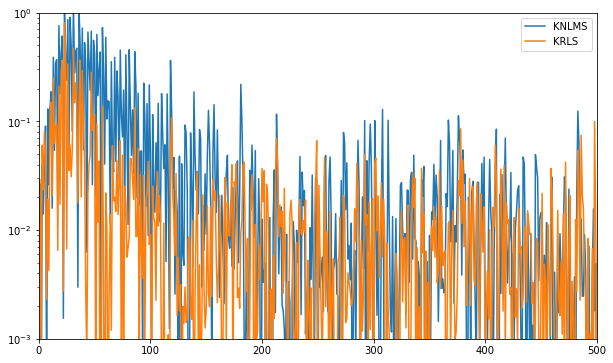

In [27]:
mse_KNLMS_smooth = np.convolve(mse_KNLMS,np.ones(19),'valid')
mse_KRLS_smooth = np.convolve(mse_KRLS,np.ones(19),'valid')
plt.figure(figsize=(10, 6))
plt.semilogy(range(len(mse_KNLMS)),mse_KNLMS, label='KNLMS')
plt.semilogy(range(len(mse_KRLS)),mse_KRLS, label='KRLS')
plt.ylim([1e-3,1e-0])
plt.xlim([0,500])
plt.legend()
plt.show()

In [31]:
d,d_true = generate_data(num_data)
err_KNLMS = KNLMS(d,kernel,step_size,reg_coeff,0.5)
mse_KNLMS = np.append(mse_KNLMS, (np.array(d_true) - np.array(d) + err_KNLMS)**2)
print('mse_KNLMS',len(err_KNLMS))
err_KRLS = KRLS(d,kernel,0.6)
mse_KNLMS = np.append(mse_KNLMS, (np.array(d_true) - np.array(d) + err_KRLS)**2)
print('mse_KRLS',len(err_KRLS))

number of SVs 24
mse_KNLMS 3000
mse_KRLS 3000


# Kernel Approximation using Random Fourier Features
**Require**: A positive definite shift-invariant kernel $k(x, y) = k(x − y)$.

**Ensure**: A randomized feature map $z(\textbf{x}) : \mathbb{R}^d \to \mathbb{R}^D$ so that 
$z(x)'z(y) \approx k(x − y)$

Compute the Fourier transform p of the kernel $k: p(\omega) = \frac{1}{2\pi}\int e^{−j\omega \theta}\delta k(\delta)d\Delta.$

Draw $D$ iid samples $\omega_1, \cdots, \omega_D \in \mathbb{R}^D$

from $p$ and $D$ iid samples $b_1, . . . , b_D \in \mathbb{R}$ from the uniform distribution on $[0,2\pi]$

Let $z(x) ≡\sqrt{\frac{2}{D}}[ cos(\omega_1'\textbf{x}+b_1) ··· cos(\omega_D'\textbf{x}+b_D)]'$

In this case 
$$ p(\omega) = (2\pi)^{-D/2}e^{-\|\omega\|_2^2/2}$$

In [55]:
d,d_true = generate_data(num_data)
d = d.reshape(-1, 1)
X = np.empty((d.shape[0],2))
X[0,0] = d[0]
X[0,1] = d[1]
for i in range(1,len(d)):
    X[i,0] = d[i-1]
    X[i,1] = d[i]

In [101]:
# Size of dictionary
D = 1000
# p_omega = lambda D,omega:((2*np.pi) ** (-D/2)) * (np.exp((np.linalg.norm(omega, ord=2)**2)/2))

W = np.random.normal(loc=0, scale=2.25, size=(D,2))
b = np.random.uniform(0,2*np.pi,D)
B = np.repeat(b[:, np.newaxis], len(d), axis=1)
z = np.sqrt(2/D) * np.cos(W @ X.T + B)

# Kernel approximate
kernel = z.T @ z
plt.imshow(kernel)
kernel

In [193]:
# d,d_true = generate_data(num_data)
# d = d.reshape(-1, 1)
k = np.empty((d.shape[0],d.shape[0]),dtype=object)
Y = np.empty((d.shape[0]),dtype=object)
Y[0] = np.array([d[0],d[1]])
for i in range(1,len(d)):
    Y[i] = np.array([d[i-1],d[i]])

# for i in range(len(k)):
#     for j in range(len(k)):
#         k[i,j] = gauss_kernel(X[i],X[j])
        
# k
# X = np.array([d[0],d[1]],dtype=np.ndarray)
# X = np.r_[X,[d[0],d[1]]]

    
# gauss_kernel = lambda u_i,u_j: np.exp(-3.73 * (np.linalg.norm(u_i - u_j,ord=2)**2))
# x = np.repeat(X,X.shape[0],axis=1)
# y = x.T
# k = gauss_kernel(x,y)
# k.shape

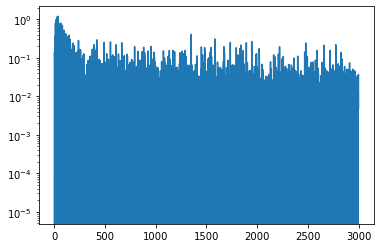

In [63]:
def KLMS_RFF(d,kernel,step_size,reg_coeff,threshold,D):
    
    err = np.array([])
    W = np.random.normal(loc=0, scale=2.25, size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)

    # Initialization
    m = 1
    u_0 = np.array([d[0],d[1]]).reshape(2,1)

    h = np.sqrt(2/D) * np.cos(W.T @ u_0 + b)

    alpha = np.zeros((D,1))
    err = np.append(err,d[0] - h.T @ alpha)
    alpha = alpha + step_size * err[-1] * h
    for n in range(1, len(d)):
        u_n = np.array([d[n-1],d[n]]).reshape(2,1)
        d_n = d[n]
        h = np.sqrt(2/D) * np.cos(W.T @ u_n + b)        
        err = np.append(err, d_n - h.T @ alpha)
        alpha = alpha + step_size * err[-1] * h
    return err
d,d_true = generate_data(num_data)
mse_KLMS_RFF = KLMS_RFF(d,kernel,step_size,reg_coeff,threshold,100)
plt.semilogy(mse_KLMS_RFF)

In [33]:
def KLMS(d,kernel,step_size,reg_coeff,threshold):
    
    err = np.array([])
    # Initialization
    u_0 = np.array([d[0],d[1]]).reshape(2,1)

    h = np.zeros((D,1))
    alpha = np.zeros((D,1))
    err = np.append(err,d[0] - h.T @ alpha)
    alpha = alpha + step_size * err[-1] * h
    
    for n in range(1, len(d)):
        u_n = np.array([d[n-1],d[n]]).reshape(2,1)
        d_n = d[n]
        h = np.sqrt(2/D) * np.cos(W.T @ u_n + b)        
        err = np.append(err, d_n - h.T @ alpha)
        alpha = alpha + step_size * err[-1] * h
    return err
d,d_true = generate_data(num_data)
mse_KLMS = KLMS(d,kernel,step_size,reg_coeff,threshold)
plt.semilogy(mse_KLMS)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# def KNLMS_RFF(d,d_true,kernel,step_size,reg_coeff,threshold,D):
    
#     err = np.array([])
#     W = np.random.normal(loc=0, scale=2.25, size=(D,2))
#     b = np.random.uniform(0,2*np.pi,D)
#     B = np.repeat(b[:, np.newaxis], len(d), axis=1)
#     z = np.sqrt(2/D) * np.cos(W @ X.T + B)
    
    
#     # Initialization
#     m = 1
#     u = np.matrix([d[0],d[1]])
#     dictionary = np.matrix(u)

#     h = np.matrix(kernel(u,dictionary))
#     alpha = np.matrix(0)
    
#     err = np.append(err,d[0] - h.T @ alpha)
#     for n in range(1, len(d)):
#         u_n = np.matrix([d[n-1],d[n]])
#         d_n = np.matrix(d[n])

#         if np.max(np.abs([kernel(u_n,dictionary[j]) for j in range(len(dictionary))])) < threshold:
#             m += 1
#             dictionary = np.r_[dictionary, u_n]
#             h = np.matrix([kernel(u_n,dictionary[j]) for j in range(len(dictionary))]).T
#             alpha = np.r_[alpha,[[0]]]

#         h = np.matrix([kernel(u_n,dictionary[j]) for j in range(len(dictionary))]).T
#         alpha = alpha + (step_size/(reg_coeff + (np.linalg.norm(h,ord=2)**2)))*((d_n - h.T @ alpha).item() * h)
#         err = np.append(err,d_n - h.T @ alpha)

# #     print('number of SVs',len(dictionary))
#     return err